In [1]:
import os
import time
import glob
import re
from functools import reduce
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd
from klepto.archives import dir_archive


import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib.pyplot as plt



In [2]:
#define processor

class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
        
        #define bins
        dataset_axis         = hist.Cat("dataset", "Primary dataset")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 500, 0, 2000)
        mass_axis            = hist.Bin("mass", r"$mass$ (GeV)", 500, 0, 2000)
        eta_axis             = hist.Bin("eta", r"$\eta$", 80, -4, 4)
        phi_axis             = hist.Bin("phi", r"$\Delta \phi$", 80, 0, 4)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)
        multiplicity_axis    = hist.Bin("multiplicity", r"N", 30, -0.5, 29.5)
        
        #define dictionary for plots
        self._accumulator = processor.dict_accumulator({
            "dPhi_H_j" :                hist.Hist("Counts", dataset_axis, phi_axis),
            "dPhi_H_b" :                hist.Hist("Counts", dataset_axis, phi_axis),
            "dPhi_H_nonb" :             hist.Hist("Counts", dataset_axis, phi_axis),
            "dR_H_j" :                  hist.Hist("Counts", dataset_axis, r_axis),
            "dR_H_b" :                  hist.Hist("Counts", dataset_axis, r_axis),
            "dR_H_nonb" :               hist.Hist("Counts", dataset_axis, r_axis),
            "dPhi_W_j" :                hist.Hist("Counts", dataset_axis, phi_axis),
            "dPhi_W_b" :                hist.Hist("Counts", dataset_axis, phi_axis),
            "dPhi_W_nonb" :             hist.Hist("Counts", dataset_axis, phi_axis),
            "dR_W_j" :                  hist.Hist("Counts", dataset_axis, r_axis),
            "dR_W_b" :                  hist.Hist("Counts", dataset_axis, r_axis),
            "dR_W_nonb" :               hist.Hist("Counts", dataset_axis, r_axis),
            "dPhi_MET_leadj":           hist.Hist("Counts", dataset_axis, phi_axis),
            "dPhi_MET_leadb":           hist.Hist("Counts", dataset_axis, phi_axis),
            "dPhi_MET_leadnonb":        hist.Hist("Counts", dataset_axis, phi_axis), 
            "dPhi_MET_leadH":           hist.Hist("Counts", dataset_axis, phi_axis),
            "dPhi_MET_leadW":           hist.Hist("Counts", dataset_axis, phi_axis),
            "mindPhi_leadH_leadW":      hist.Hist("Counts", dataset_axis, phi_axis),
            "mindPhi_leadjets":         hist.Hist("Counts", dataset_axis, phi_axis),
            })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, df):
        
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content, 
            btag=df['FatJet_btagDeepB'].content, 
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW = df['FatJet_deepTagMD_WvsQCD'].content, 
            fatjetid=df['FatJet_jetId'].content,
        )
        
        #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        leadjetcut = (goodjets.pt.argmax())
        leadjet = goodjets[leadjetcut]
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        leadbjetcut = (bjets.pt.argmax())
        leadbjet = bjets[leadbjetcut]
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        leadnbjetcut = (nbjets.pt.argmax())
        leadnbjet = nbjets[leadnbjetcut]

        #ak8's
        goodfjcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0))
        goodfatjets = fatjets[goodfjcut]
        htagcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromH > 0.8365))
        htagged = fatjets[htagcut]
        leadhtagcut = (htagged.pt.argmax())
        leadhtagged = htagged[leadhtagcut]
        wtagcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromW > 0.9) & (fatjets.fromH < 0.8365))
        wtagged = fatjets[wtagcut]
        leadwtagcut = (wtagged.pt.argmax())
        leadwtagged = wtagged[leadwtagcut]
        

        #match jets
   
        jmatchleadH = leadhtagged.cross(goodjets)
        jmatchleadHDR = jmatchleadH.i0.p4.delta_r(jmatchleadH.i1.p4)
        jmatchleadHDPhi = abs(jmatchleadH.i0.p4.delta_phi(jmatchleadH.i1.p4))

        bmatchleadH = leadhtagged.cross(bjets)
        bmatchleadHDR = bmatchleadH.i0.p4.delta_r(bmatchleadH.i1.p4)
        bmatchleadHDPhi = abs(bmatchleadH.i0.p4.delta_phi(bmatchleadH.i1.p4))
        
        nbmatchleadH = leadhtagged.cross(nbjets)
        nbmatchleadHDR = nbmatchleadH.i0.p4.delta_r(nbmatchleadH.i1.p4)
        nbmatchleadHDPhi = abs(nbmatchleadH.i0.p4.delta_phi(nbmatchleadH.i1.p4))
        
        jmatchleadW = leadwtagged.cross(goodjets)
        jmatchleadWDR = jmatchleadW.i0.p4.delta_r(jmatchleadW.i1.p4)
        jmatchleadWDPhi = abs(jmatchleadW.i0.p4.delta_phi(jmatchleadW.i1.p4))

        bmatchleadW = leadwtagged.cross(bjets)
        bmatchleadWDR = bmatchleadW.i0.p4.delta_r(bmatchleadW.i1.p4)
        bmatchleadWDPhi = abs(bmatchleadW.i0.p4.delta_phi(bmatchleadW.i1.p4))
           
        nbmatchleadW = leadwtagged.cross(nbjets)
        nbmatchleadWDR = nbmatchleadW.i0.p4.delta_r(nbmatchleadW.i1.p4)
        nbmatchleadWDPhi = abs(nbmatchleadW.i0.p4.delta_phi(nbmatchleadW.i1.p4))

        #match phi
        
        jmatchMETDPhi = abs((leadjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        bmatchMETDPhi = abs((leadbjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        nonbmatchMETDPhi = abs((leadnbjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        HmatchMETDPhi = abs((leadhtagged.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        WmatchMETDPhi = abs((leadwtagged.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        
        

        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (df['MET_pt']>250)
        njet_ps = (df['GoodJet_pt'].counts >= 2)
        bjet_ps = (df['BJet_pt'].counts >= 1)
        ht_ps = (ht > 300)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        sel = presel & (htagged.counts > 0) & (wtagged.counts > 0) 

        
        
        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 137* 1000

        #FILL OUTPUTS

        output['dR_H_j'].fill(dataset=dataset, r=jmatchleadHDR[sel].flatten(), weight=wght)
        output['dPhi_H_j'].fill(dataset=dataset, phi=jmatchleadHDPhi[sel].flatten(), weight=wght)
        output['dR_H_b'].fill(dataset=dataset, r=bmatchleadHDR[sel].flatten(), weight=wght)
        output['dPhi_H_b'].fill(dataset=dataset, phi=bmatchleadHDPhi[sel].flatten(), weight=wght)
        output['dR_H_nonb'].fill(dataset=dataset, r=nbmatchleadHDR[sel].flatten(), weight=wght)
        output['dPhi_H_nonb'].fill(dataset=dataset, phi=nbmatchleadHDPhi[sel].flatten(), weight=wght)
        output['dR_W_j'].fill(dataset=dataset, r=jmatchleadWDR[sel].flatten(), weight=wght)
        output['dPhi_W_j'].fill(dataset=dataset, phi=jmatchleadWDPhi[sel].flatten(), weight=wght)
        output['dR_W_b'].fill(dataset=dataset, r=bmatchleadWDR[sel].flatten(), weight=wght)
        output['dPhi_W_b'].fill(dataset=dataset, phi=bmatchleadWDPhi[sel].flatten(), weight=wght)
        output['dR_W_nonb'].fill(dataset=dataset, r=nbmatchleadWDR[sel].flatten(), weight=wght)
        output['dPhi_W_nonb'].fill(dataset=dataset, phi=nbmatchleadWDPhi[sel].flatten(), weight=wght)
        
        output['dPhi_MET_leadj'].fill(dataset=dataset, phi=jmatchMETDPhi[sel].flatten(), weight=wght)
        output['dPhi_MET_leadb'].fill(dataset=dataset, phi=bmatchMETDPhi[sel].flatten(), weight=wght)
        output['dPhi_MET_leadnonb'].fill(dataset=dataset, phi=nonbmatchMETDPhi[sel].flatten(), weight=wght)
        output['dPhi_MET_leadH'].fill(dataset=dataset, phi=HmatchMETDPhi[sel].flatten(), weight=wght)
        output['dPhi_MET_leadW'].fill(dataset=dataset, phi=WmatchMETDPhi[sel].flatten(), weight=wght)
        
        
        

        return output

    
    def postprocess(self, accumulator):
        return accumulator
        

In [3]:
fileset_sig = {'mC750_l1': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/WH_had_750_1__nanoAOD/merged/WH_had_750_1__nanoAOD_1.root']}
fileset_back = {'W+Jets': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                          ],
                'QCD':[#'/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv96/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       #'/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv96/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                    ],
            'TTJets':['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                   ],
            "ZNuNu":['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-600To800_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-600To800_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-800To1200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-800To1200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                     ]
               }


output_sig = processor.run_uproot_job(fileset_sig,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_back = processor.run_uproot_job(fileset_back,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )



In [4]:
histograms = ["dR_H_j","dPhi_H_j","dR_H_b","dPhi_H_b","dR_H_nonb","dPhi_H_nonb",
             "dR_W_j","dPhi_W_j","dR_W_b","dPhi_W_b","dR_W_nonb","dPhi_W_nonb",
             "dPhi_MET_leadj", "dPhi_MET_leadb", "dPhi_MET_leadnonb", "dPhi_MET_leadH",
             "dPhi_MET_leadW"]

outdir = "/home/users/mbryson/public_html/dump/WH/angles"

In [5]:
lineopts = {
    'color': 'r',
}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1,
}

lineopts2 = {
    'color': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0')],
}
fillopts1 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0')],
}


def savefig(signal, background, outdir, name):
    ax = hist.plot1d(background, overlay="dataset", density=False, stack=True, 
                fill_opts = fillopts1, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", density=False, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.001,1000000)
    ax.figure.savefig(os.path.join(outdir, "{}_log.png".format(name)))
    ax.clear()


    
def savefigshape(signal, background, outdir, name):
    ax = hist.plot1d(background, overlay="dataset", density=True, stack=False, 
                line_opts = lineopts2, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", density=True, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.00001,10)
    ax.figure.savefig(os.path.join(outdir, "{}_shape_log.png".format(name)))
    ax.clear()

dR_H_j
dPhi_H_j
dR_H_b
dPhi_H_b
dR_H_nonb
dPhi_H_nonb
dR_W_j
dPhi_W_j
dR_W_b
dPhi_W_b
dR_W_nonb
dPhi_W_nonb
dPhi_MET_leadj
dPhi_MET_leadb
dPhi_MET_leadnonb
dPhi_MET_leadH
dPhi_MET_leadW


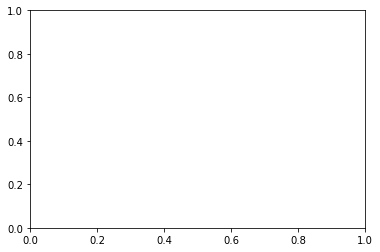

In [6]:
for name in histograms:
    print (name)
    histo_sig = output_sig[name]
    histo_back = output_back[name]
    #rebinning
    if name == "dR_H_j":
        new_drhj_bins = hist.Bin('r', r' $\Delta R$(lead H, jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhj_bins)
        histo_back = histo_back.rebin('r', new_drhj_bins)
    if name == "dPhi_H_j":
        new_dphj_bins = hist.Bin('phi', r' $\Delta \Phi$(lead H, jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphj_bins)
        histo_back = histo_back.rebin('phi', new_dphj_bins)
    if name == "dR_H_b":
        new_drhb_bins = hist.Bin('r', r' $\Delta R$(lead H, b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhb_bins)
        histo_back = histo_back.rebin('r', new_drhb_bins)
    if name == "dPhi_H_b":
        new_dphb_bins = hist.Bin('phi', r' $\Delta \Phi$(lead H, b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphb_bins)
        histo_back = histo_back.rebin('phi', new_dphb_bins)
    if name == "dR_H_nonb":
        new_drhnb_bins = hist.Bin('r', r' $\Delta R$(lead H, non b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhnb_bins)
        histo_back = histo_back.rebin('r', new_drhnb_bins)
    if name == "dPhi_H_nonb":
        new_dphnb_bins = hist.Bin('phi', r' $\Delta \Phi$(lead H, non b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphnb_bins)
        histo_back = histo_back.rebin('phi', new_dphnb_bins)
    if name == "dR_W_j":
        new_drwj_bins = hist.Bin('r', r' $\Delta R$(lead W, jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwj_bins)
        histo_back = histo_back.rebin('r', new_drwj_bins)
    if name == "dPhi_W_j":
        new_dpwj_bins = hist.Bin('phi', r' $\Delta \Phi$(lead W, jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpwj_bins)
        histo_back = histo_back.rebin('phi', new_dpwj_bins)
    if name == "dR_W_b":
        new_drwb_bins = hist.Bin('r', r' $\Delta R$(lead W, b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwb_bins)
        histo_back = histo_back.rebin('r', new_drwb_bins)
    if name == "dPhi_W_b":
        new_dpwb_bins = hist.Bin('phi', r' $\Delta \Phi$(lead W, b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphb_bins)
        histo_back = histo_back.rebin('phi', new_dphb_bins)
    if name == "dR_W_nonb":
        new_drwnb_bins = hist.Bin('r', r' $\Delta R$(lead W, non b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwnb_bins)
        histo_back = histo_back.rebin('r', new_drwnb_bins)
    if name == "dPhi_W_j":
        new_dpwnb_bins = hist.Bin('phi', r' $\Delta \Phi$(lead W, non b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpwnb_bins)
        histo_back = histo_back.rebin('phi', new_dpwnb_bins)
    if name == "dPhi_MET_leadj":
        new_dpmj_bins = hist.Bin('phi', r' $\Delta \Phi$(MET, lead jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmj_bins)
        histo_back = histo_back.rebin('phi', new_dpmj_bins)
    if name == "dPhi_MET_leadb":
        new_dpmb_bins = hist.Bin('phi', r' $\Delta \Phi$(MET, lead b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmb_bins)
        histo_back = histo_back.rebin('phi', new_dpmb_bins)
    if name == "dPhi_MET_leadnonb":
        new_dpmnb_bins = hist.Bin('phi', r' $\Delta \Phi$(MET, lead non b jet) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmnb_bins)
        histo_back = histo_back.rebin('phi', new_dpmnb_bins)    
    if name == "dPhi_MET_leadH":
        new_dpmh_bins = hist.Bin('phi', r' $\Delta \Phi$(MET, lead H) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmh_bins)
        histo_back = histo_back.rebin('phi', new_dpmh_bins)      
    if name == "dPhi_MET_leadW":
        new_dpmw_bins = hist.Bin('phi', r' $\Delta \Phi$(MET, lead W) ', 40, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmw_bins)
        histo_back = histo_back.rebin('phi', new_dpmw_bins)          
    savefig(histo_sig, histo_back,outdir, name)
    savefigshape(histo_sig, histo_back,outdir, name)